In [1]:
import numpy as np
from matplotlib import pyplot as plt, rcParams
import torch
import torch.optim as optim
import torch.nn as nn

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
np.random.seed(42)
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.serif"] = "Bitstream Vera Serif"
rcParams["font.family"] = "serif"

# Generating Toy Data
Generate signal mass from a uniform + gaussian distribution.

Generate background mass from a linear distribution $ ax + b $ (with $ a = \frac{1}{4} $ and $ b = \frac{1}{2} $ ) using inversion transform sampling.

Generate random gaussian variables uncorrelated with mass but slightly different for signal and background.

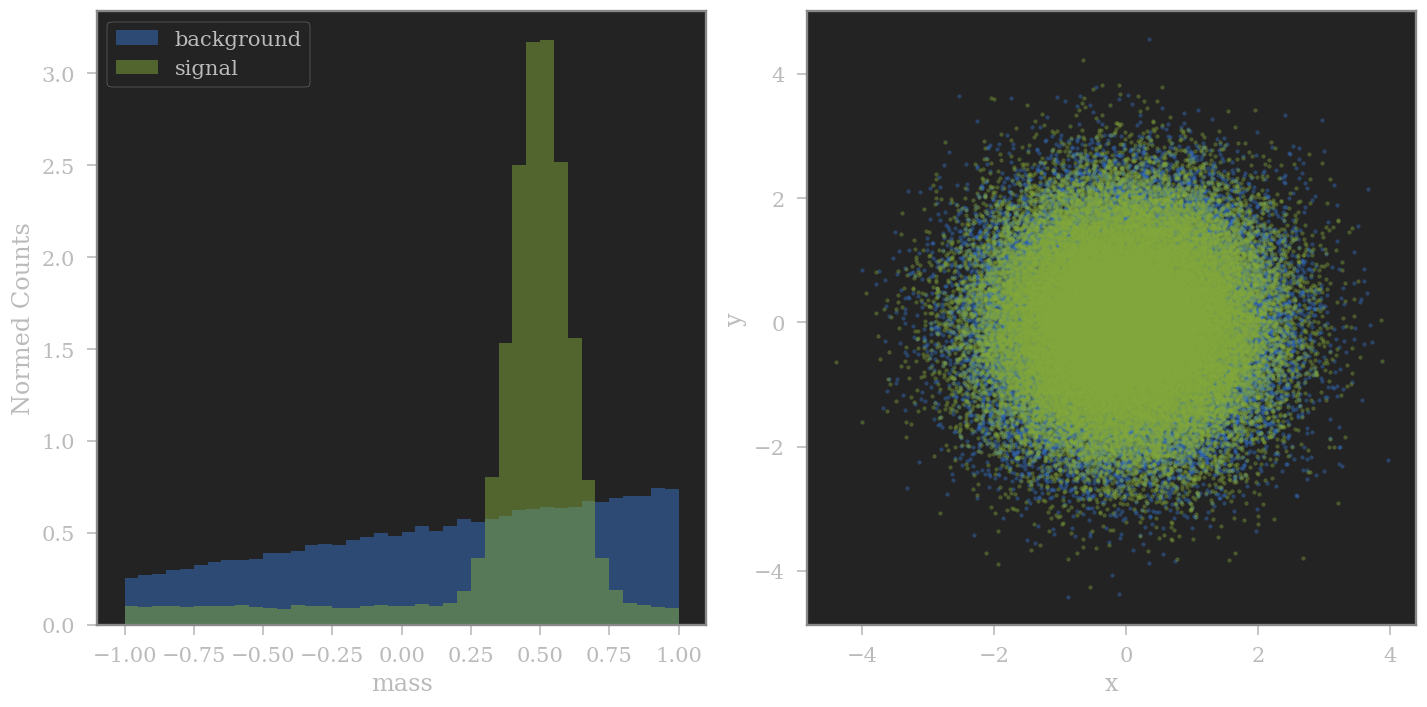

In [2]:
n_s = int(5e4)
n_b = int(5e4)
n_s_gauss_frac = 0.8

a = 1/4 
b = 1/2

u = np.random.uniform(0,1,50000)
u_ = np.random.uniform(0,1,50000)

m_b = - b/(a) + np.sqrt((b-a)**2 + 2*a*u)/(a)
m_s = np.concatenate([np.random.uniform(-1,1,n_s-int(n_s_gauss_frac*n_s)), 
                    np.random.normal(0.5,0.1,size=int(n_s_gauss_frac*n_s))])
m_t = -b/(a) + np.sqrt((b-a)**2 + 2*a*u_)/(a)
m_t.sort()

x_b,y_b  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T
x_s,y_s  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_s).T
x_t,y_t  = np.random.multivariate_normal((0,0),[[1,0],[0,1]],size=n_b).T

fig ,[ax1,ax2] = plt.subplots(1,2,figsize=(12,6),dpi=120)

_,bins,_ = ax1.hist(m_b,bins=40,density=True,alpha=0.5, label='background')
ax1.hist(m_s,bins=bins,density=True,alpha=0.5,label='signal')
ax1.legend()
ax1.set_xlabel("mass")
ax1.set_ylabel("Normed Counts")

ax2.scatter(x_b,y_b,s=5,alpha=0.4)
ax2.scatter(x_s,y_s,s=5,alpha=0.4)
ax2.set_xlabel("x")
ax2.set_ylabel("y")

#ax2.set_title("Data")
#plt.savefig("./plots/Data.pdf")
plt.tight_layout()
plt.show()

In [3]:
x = np.concatenate([np.stack([m_s,x_s,y_s],axis=1),
                   np.stack([m_b,x_b,y_b],axis=1)])
    
#x = np.concatenate([m_s,m_b])
y = np.concatenate([np.ones(m_s.size),np.zeros(m_b.size)])

x_test = np.stack([m_t,x_t,y_t],axis=1) #,x_test,y_test
y_test = np.ones(n_b)
# Shuffling the data
size = y.size
mask = np.arange(size)
np.random.shuffle(mask)

# Train Validation Split
x_train = x[mask][:int(size*0.8)]
y_train = y[mask][:int(size*0.8)]

x_val = x[mask][int(size*0.8):]
y_val = y[mask][int(size*0.8):]

# Torch Tensors
x_train_tensor = torch.from_numpy(x_train).float().view(-1,3)
y_train_tensor = torch.from_numpy(y_train).float().view(-1,1)
x_val_tensor = torch.from_numpy(x_val).float().view(-1,3)
y_val_tensor = torch.from_numpy(y_val).float().view(-1,1)
x_test_tensor = torch.from_numpy(x_test).float().view(-1,3)
y_test_tensor = torch.from_numpy(y_test).float().view(-1,1)

In [4]:

# Creating the torch model
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3,16)
        self.linear2 = nn.Linear(16,32)
        self.out = nn.Linear(32,1)
        # Defaults
        self.n_epochs = 200
        self.optimizer = torch.optim.SGD(self.parameters(),lr=1e-1)
        #self.loss = torch.nn.MSELoss()
        
    def forward(self, x):
        x = nn.functional.relu(self.linear(x))
        x = nn.functional.relu(self.linear2(x))
        x = torch.sigmoid(self.out(x))
        return x
    
    def fit(self,x,y,n_epochs=None,optimizer=None,loss=None,interval=100,val_data=[],metrics=[]):
        if n_epochs: 
            self.n_epochs = n_epochs
        if optimizer: 
            self.optimizer = optimizer
        if loss:
            self.loss = loss
        for epoch in range(self.n_epochs):
            self.train()
            yhat = self(x)
            l = self.loss(yhat,y)
            l.backward()    
            self.optimizer.step()
            self.optimizer.zero_grad()
            
            if metrics:
                if type(metrics) == list:
                    metrics[0].calculate(pred=yhat,target=y)
                else:
                    metrics.calculate(pred=yhat,target=y,l=l.item())

        #Validation and Printing
            if val_data:
                if epoch % interval ==0 or epoch == self.n_epochs-1:
                    self.train(False)
                    yhat_val = self(val_data[0])
                    l_val = torch.nn.MSELoss()(yhat_val,val_data[1] )
                    if len(metrics)>1:
                        metrics[1].calculate(pred=yhat_val,target=val_data[1],l=l_val.item())
                    acc = metrics[0].accs[-1]
                    acc_val = metrics[1].accs[-1]
                    print('Epoch:{:04d}/{:04d} || Train: loss:{:.4f}, acc:{:.0f}% || Test: loss: {:.4f}, acc:{:.0f}%'.format(
                    epoch,n_epochs,l.item(), 100.* acc,
                    l_val.item(), 100.* acc_val))
            else:
                if epoch % interval ==0:
                    acc = metrics[0].accs[-1]
                    print('Epoch:{:04d}/{:04d} loss: {:.4f}, accuracy:({:.0f}%)'.format(
                        epoch,n_epochs,l.item(), 100.* acc))
                
    
#define some lists to fill
class Metrics():
    def __init__(self):
        self.losses = []
        self.accs = []
        self.signalE = []
        self.backgroundE= []
    def calculate(self,pred,target,l=None,validation=False):
        acc = (pred.round()==target).sum().item()/target.shape[0]
        signal_efficiency = ((pred.round()==target)&(target==1)).sum().item()/(target==1).sum().item()
        background_efficiency = ((pred.round()==target)&(target==0)).sum().item()/(target==0).sum().item()
        self.accs.append(acc)
        self.signalE.append(signal_efficiency)
        self.backgroundE.append(background_efficiency)
        if l:
            self.losses.append(l)
            

In [5]:
class LegendreLoss():
    def __init__(self,frac=0.9):
        self.frac = frac
        self.mass = np.sort(x_train[:,0])
        self.ordered_mass = np.argsort(x_train[:,0])
        self.dm = torch.from_numpy(self.mass.reshape(-1,100)[:,-1] - self.mass.reshape(-1,100)[:,0]).float().view(-1,1)
        self.m = torch.from_numpy(self.mass.reshape(-1,100).mean(axis=1)).float().view(-1,1)
        self.p0 = 1
        self.p1 = self.m
        self.p2 = (self.m**2-1)/2
        self.scores = 0
        self.legendre = 0
    def __call__(self,pred,target):   
        pred_bins = pred[self.ordered_mass].reshape(-1,100)
        ordered_s = pred_bins.argsort(axis=1)
        self.scores = pred_bins.gather(1,ordered_s) # ordered in mass bins in axis 0 and ordered in score in axis 1
        a0 = 1/2 * (self.scores*self.dm).sum(axis=0)
        a1 = 3/2 * (self.scores*self.p1*self.dm).sum(axis=0)
        #mean = pred[self.ordered].reshape(-1,100).mean(axis=1)
        #a0 = 1/2 * (mean*self.dm).sum()
        #a1 = 3/2 * (mean*self.p1*self.dm).sum()
        #a2 = 5/2 * (mean*self.p2*self.dm).sum()
        self.legendre = a0 + a1*self.p1 #+ a2*self.p2
        legendre_loss = ((self.scores - self.legendre)**2).mean()
        return legendre_loss*self.frac + torch.nn.MSELoss()(pred,target)*(1-self.frac)

    
class JiangLoss():
    def __init__(self):
        self.gx = (x_train[:,0]<.75)&(x_train[:,0]>.25)
        self.ytrue = (y_train==1)
        self.Z_g = self.gx.sum()/x_train.size
        self.P_g = (self.ytrue&self.gx).sum()/x_train.size
        self.P_x = (self.ytrue).sum()/x_train.size
        self.cx = (self.gx/self.Z_g -1)
        self.lambda1 = 0
        self.weights = np.ones_like(y_train)
        self.eta = 1e-2 #1e-3
        self.scores = torch.from_numpy(np.random.randint(0,2,size=y_train.size))
    def __call__(self,pred,target):
        self.weights = np.array(self.weights.tolist()).flatten()
        self.delta =  (np.array(self.scores.tolist()).flatten()*self.cx).mean()      # +(1-yhat)*0
        self.lambda1 -= self.eta*self.delta
        weights_ = np.exp(self.lambda1*self.cx)
        self.weights[y_train==1] = (weights_/(1+weights_))[y_train==1]
        self.weights[y_train==0] = (1/(1+weights_))[y_train==0]
        self.weights = torch.from_numpy(self.weights).view(-1,1)
        self.scores = pred
        return torch.mean(self.weights*(pred-target)**2)

In [ ]:
metrics_train_base = Metrics()
metrics_val_base = Metrics()
model_base = Classifier()
model_base.loss = torch.nn.MSELoss()
model_base.fit(x_train_tensor,y_train_tensor,n_epochs=2000,metrics=[metrics_train_base,metrics_val_base], val_data=[x_val_tensor,y_val_tensor])

Epoch:0000/2000 || Train: loss:0.2500, acc:51% || Test: loss: 0.2498, acc:51%
Epoch:0100/2000 || Train: loss:0.2483, acc:56% || Test: loss: 0.2482, acc:56%
Epoch:0200/2000 || Train: loss:0.2465, acc:58% || Test: loss: 0.2466, acc:58%
Epoch:0300/2000 || Train: loss:0.2444, acc:61% || Test: loss: 0.2446, acc:60%
Epoch:0400/2000 || Train: loss:0.2419, acc:63% || Test: loss: 0.2422, acc:63%


In [ ]:
scores = np.array(model_base(x_test_tensor).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


ax, fig = plt.subplots(1,1,figsize=[8,5],dpi=120)
for i in range(10,scores.shape[1]-10,10):
    plt.scatter(m,scores[:,i],label=f"resp {int(i*100/scores.shape[1])}",alpha=0.7,s=2)
    #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
plt.xlabel("mass")
plt.ylabel(r"$\hat{y}$")
plt.title("Legendre Loss Model Response")
plt.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=2)
#plt.ylim([0,1])
plt.show()

In [ ]:
metrics_train_legendre = Metrics()
metrics_val_legendre = Metrics()
model_legendre = Classifier()
model_legendre.loss = LegendreLoss(frac=0.3)
model_legendre.fit(x_train_tensor,y_train_tensor,n_epochs=2000,metrics=[metrics_train_legendre,metrics_val_legendre], val_data=[x_val_tensor,y_val_tensor])

In [ ]:
scores = np.array(model_legendre(x_test_tensor).tolist()).reshape(-1,100)
m = m_t.reshape(-1,100).mean(axis=1)
ordered_score = scores.argsort(axis=1)
scores = scores[np.arange(scores.shape[0])[:, None], ordered_score]


ax, fig = plt.subplots(1,1,figsize=[8,5],dpi=120)
for i in range(10,scores.shape[1]-10,10):
    plt.scatter(m,scores[:,i],label=f"{int(i*100/scores.shape[1])}",alpha=0.7,s=2)
    #plt.plot(m,legendre[:,i*10],label="fit",ls='--')
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
plt.xlabel("mass")
plt.ylabel(r"$\hat{y}$")
plt.title("Legendre Loss Model Response")
plt.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)
#plt.ylim([0,1])
plt.show()

In [ ]:
metrics_train_jiang = Metrics()
metrics_val_jiang = Metrics()
model_jiang = Classifier()
model_jiang.loss = JiangLoss()
model_jiang.fit(x_train_tensor,y_train_tensor,n_epochs=1400,metrics=[metrics_train_jiang,metrics_val_jiang], val_data=[x_val_tensor,y_val_tensor])

In [ ]:
jiang_scores = np.array(model_jiang.loss.yhat[model_legendre.loss.ordered_mass].tolist()).reshape(-1,100)
ordered_score = jiang_scores.argsort(axis=1)
jiang_scores = jiang_scores[np.arange(jiang_scores.shape[0])[:, None], jiang_scores.argsort(axis=1)]

ax, fig = plt.subplots(1,1,figsize=[8,5],dpi=120)
for i in range(5):
    plt.scatter(m,jiang_scores[:,i*10],label=f"{int(i*100/5)}",alpha=0.7,s=2)
#plt.scatter(x_train[:,0],jiang_scores,label="Jiang Response",c='w',alpha=0.5,s=1)
plt.xlabel("mass")
plt.ylabel(r"$\hat{y}$")
plt.title("Jiang Loss Model Response")
plt.legend(loc=(1,0),markerscale=5,title="Percentile",ncol=1)
plt.ylim([0,1])
plt.show()